In [4]:
from IPython.display import display,HTML
display(HTML("<style>.container {width:95% !important ; }</style>"))

# packages

In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager
from sklearn.preprocessing import StandardScaler

import warnings 

warnings.filterwarnings('ignore')

# ADP 26회 실기 문제

# 머신러닝 - 데이터 설명
- 데이터 설명
    - InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.     
    - StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.     
    - Description: Product (item) name. Nominal.    
    - Quantity: The quantities of each product (item) per transaction. Numeric.     
    - InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.   
    - UnitPrice: Unit price. Numeric, Product price per unit in sterling.    
    - CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.     
    - Country: Country name. Nominal, the name of the country where each customer resides.  
    
- 출처 : - https://archive.ics.uci.edu/ml/index.phpm
- 데이터url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/26/problem1.csv

## 문제1.1 
결측치를 확인 하고, 결측치 제거 또는 대치하고 방법에 대해 설명하라

In [81]:
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/26/problem1.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
null =df.isnull().sum().to_frame().where(lambda x : x !=0).dropna().T.astype('int')


maps = {ids : price for ids,price in df[df.InvoiceNo.str[0]!='C'].groupby(['StockCode'])['UnitPrice'].mean().reset_index().values}
c_quantity_maps = {ids : price \
    for ids,price in df[(df.Quantity.notnull()) & (df.InvoiceNo.str[0] =='C')].groupby(['StockCode'])['Quantity'].mean().reset_index().values}

not_c_quantity_maps = {ids : price \
    for ids,price in df[(df.Quantity.notnull()) & (df.InvoiceNo.str[0] !='C')].groupby(['StockCode'])['Quantity'].mean().reset_index().values}

# UnitPrice 결측치는 InvoiceNo가 환불(C로시작)이 아닌 경우 값들의 StockCode를 그룹화 하여 평균 UnitPrice를 구하고 
#그에 대응하는 StockCode값들로 결측치로 채운다
df.loc[df.UnitPrice.isnull(),'UnitPrice'] =df.loc[df.UnitPrice.isnull()]['StockCode'].map(maps)
# 23416의 StockCode의 경우 unique한 값을 가지는 행이다. 이는 UnitPrice의 전체 평균값으로 대체한다
df['UnitPrice'] =df['UnitPrice'].fillna(df['UnitPrice'].mean())

df.loc[(df.Quantity.isnull()) & (df.InvoiceNo.str[0] =='C'),'Quantity'] =\
                df.loc[(df.Quantity.isnull()) & (df.InvoiceNo.str[0] =='C')]['StockCode'].map(c_quantity_maps)
df.loc[(df.Quantity.isnull()) & (df.InvoiceNo.str[0] !='C'),'Quantity'] =\
                df.loc[(df.Quantity.isnull()) & (df.InvoiceNo.str[0] !='C')]['StockCode'].map(not_c_quantity_maps)


null_after = df.isnull().sum().to_frame().where(lambda x : x !=0).dropna().T.astype('int')

null_total = pd.concat([null,null_after]).fillna(0).astype('int')
null_total.index =['결측치 처리 전 숫자','결측치 처리 후 숫자']
display(null_total)
print('''
결측치는 Quantity,UnitPrice 두 컬럼만 존재한다. Quantity 결측치는 환불을 한 경우와 그렇지 않은 경우를 나눠 각 StockCode값의 평균을 입력한다.
UnitPrice의 경우 환불이 아닌 경우만 필터하여 StockCode의 평균 값으로 대치한다. 이러한 규칙에 StockCode 23416를 가지는 행은 하나 밖에 없어
대치할 평균값이 없다 이 경우 전체 평균값으로 대치한다.
''')

,Quantity,UnitPrice
결측치 처리 전 숫자,25,97
결측치 처리 후 숫자,0,0



결측치는 Quantity,UnitPrice 두 컬럼만 존재한다. Quantity 결측치는 환불을 한 경우와 그렇지 않은 경우를 나눠 각 StockCode값의 평균을 입력한다.
UnitPrice의 경우 환불이 아닌 경우만 필터하여 StockCode의 평균 값으로 대치한다. 이러한 규칙에 StockCode 23416를 가지는 행은 하나 밖에 없어
대치할 평균값이 없다 이 경우 전체 평균값으로 대치한다.



## 문제1.2 
이상치를 제거하는 방법을 설명하고, 이상치 제거 전 후 결과에 대해 통계적인 방법을 포함하여 설명할 것

In [114]:
display(df[['Quantity','UnitPrice']].describe().T)

df_outlier_filter =df[df.UnitPrice != 0].reset_index(drop=True)

print('''
UnitPrice값이 0인 경우는 제품을 값을 내고 구매 했다는 의미가 아니므로 이상치로 보고 제거한다. 
''')


,count,mean,std,min,25%,50%,75%,max
Quantity,35801.0,18.423253,42.148403,-480.0,4.00,10.00,16.00,2400.00
UnitPrice,35801.0,4.607905,48.017794,0.0,1.25,1.95,3.75,4161.06



UnitPrice값이 0인 경우는 제품을 값을 내고 구매 했다는 의미가 아니므로 이상치로 보고 제거한다. 



## 문제1.3 
각 StockCode을 기준으로 파생변수들을 만들고 제품들의 특성에 따른 군집 생성을 위한 전처리를 수행하라. 

,Quantity,UnitPrice,Country,c_counts
StockCode,,,,
10002,0.479357,-0.155350,0.225388,-0.040673
10120,-0.229192,-0.193944,-0.393425,-0.447639
10125,0.813804,-0.161334,-0.084018,-0.003676
10133,-0.017334,-0.174798,-0.084018,-0.336648
10135,2.030633,-0.151732,-0.084018,-0.373645



반환 데이터는 900개로 전체 데이터에 크게 영향을 주지 않는다고 판단하고 제거한다. 
각 StockCode기준으로 4개의 컬럼을 생성한다.
Quantity : 각 제품별 평균 구매량
UnitPrice : 각 제품별 평균 구매금액
Country : 각 제품별 구매 국가 갯수
c_counts : 각 제품의 구매 유저 숫자
데이터 프레임 생성후 정규화를 한다. Country컬럼의 경우 다른 컬럼에 비해 분산이 크기에 3을 나눠준다.
정규화 후에도 10이상의 값을 가지는 데이터 3개가 존재하는데 이 데이터는 이상치로 보고 제거한다.



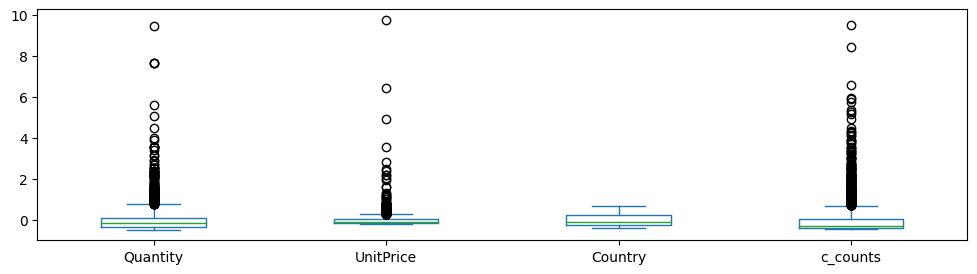

In [263]:
buy_df = df[df.InvoiceNo.str[0]!='C'].reset_index(drop=True)

contry = buy_df.groupby(['StockCode'])['Country'].agg(lambda x : list(set(x))).str.len()
# contry_dummies = pd.get_dummies(contry.explode()).groupby(level=0).sum()
custom = buy_df.groupby(['StockCode'])['CustomerID'].size()
custom.name = 'c_counts'
means = buy_df.groupby(['StockCode'])[['Quantity','UnitPrice']].mean()

t = pd.merge(pd.merge(means,contry,left_index=True,right_index=True),custom,left_index=True,right_index=True)
ss =StandardScaler()


scaled_df = t.copy()
scaled_df['Quantity'] = ss.fit_transform(scaled_df['Quantity'].values.reshape(-1,1)) 
scaled_df['UnitPrice'] = ss.fit_transform(scaled_df['UnitPrice'].values.reshape(-1,1))
scaled_df['c_counts'] = ss.fit_transform(scaled_df['c_counts'].values.reshape(-1,1)) 
scaled_df['Country'] = ss.fit_transform(scaled_df['Country'].values.reshape(-1,1)) /3
scaled_df= scaled_df[scaled_df<10].dropna()

fig,ax = plt.subplots(1,figsize=(12,3))
scaled_df.plot(kind='box',ax=ax)
display(scaled_df.head())

print('''
반환 데이터는 900개로 전체 데이터에 크게 영향을 주지 않는다고 판단하고 제거한다. 
각 StockCode기준으로 4개의 컬럼을 생성한다.
Quantity : 각 제품별 평균 구매량
UnitPrice : 각 제품별 평균 구매금액
Country : 각 제품별 구매 국가 갯수
c_counts : 각 제품의 구매 유저 숫자
데이터 프레임 생성후 정규화를 한다. Country컬럼의 경우 다른 컬럼에 비해 분산이 크기에 3을 나눠준다.
정규화 후에도 10이상의 값을 가지는 데이터 3개가 존재하는데 이 데이터는 이상치로 보고 제거한다.
''')

## 문제 2.1 
Kmeans , DBSCAN 방법 중 하나를 선택하여 군집분석을 시행하고 각 군집별 특성을 분석하라

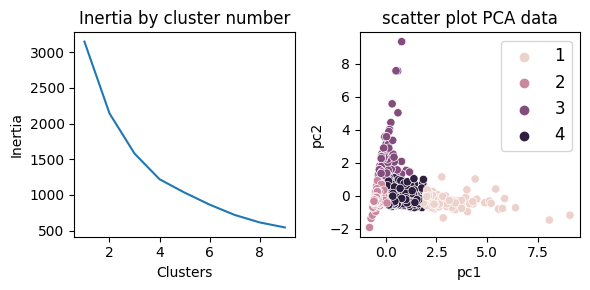

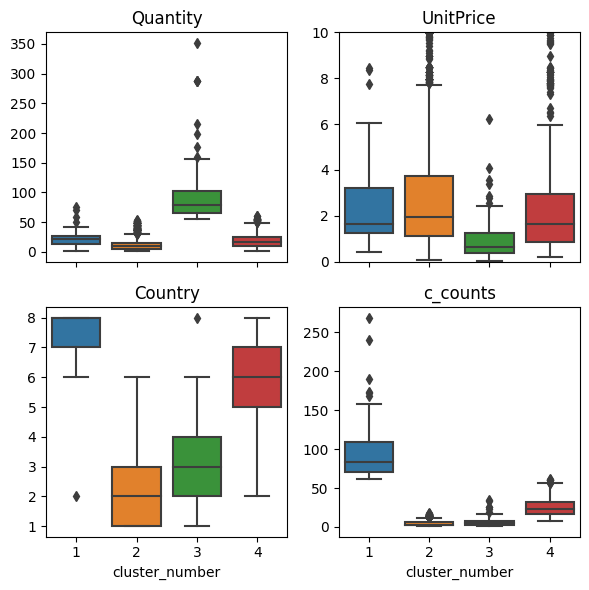


엘보우 기법을 통해 최적의 클러스터 숫자를 4개로 하고 KMeans를 시행한다.
PCA 평면에 클러스터 레이블에 대해 뿌려보면 위의 2번째 그래프와 같다. 

각 클러스터 레이블에 대한 원천데이터의 분포를 살펴보면 아래 4개 그래프와 같다.
1번 클러스터의 경우 구매국가가 가장 많고 구매 유저숫자도 많은 제품군이다. 
2번 클러스틔 경우 평균 단위 구매금액이 가장 높으며 구매 국가수와 구매 제품 수량, 구매 유저숫자가 가장 적다
3번 클러스터는 평균 단위 구매금액이 낮지만 평균 구매수량은 가장 많다.
4번 클러스터는 1,2,3들의 중간 성향을 보인다



In [306]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


fig,ax = plt.subplots(1,2,figsize=(6,3))

lst = []
for k in range(1, 10): 
    kmeans = KMeans(n_clusters=k,random_state=1)
    kmeans.fit(scaled_df)
    lst.append(kmeans.inertia_) 

ax[0].plot(range(1, 10), lst)
ax[0].set_xlabel('Clusters')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Inertia by cluster number')


n_cluter =4
km = KMeans(n_clusters=n_cluter,random_state=1)
km_pred = km.fit_predict(scaled_df)+1


pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(scaled_df),columns =['pc1','pc2'])
pca_df['cluster_label'] = km_pred
sns.scatterplot(data =pca_df,x = 'pc1',y= 'pc2',hue='cluster_label',ax=ax[1])

fig.tight_layout()
ax[1].set_title('scatter plot PCA data')
ax[1].legend(fontsize=12)
plt.show()


cluster_df = t.loc[scaled_df.index]
cluster_df['labels'] = km_pred 

fig,axes = plt.subplots(2,2,figsize=(6,6),sharex=True)

for col ,ax in zip(['Quantity','UnitPrice','Country','c_counts'],axes.flat):
    sns.boxplot(data = cluster_df[[col,'labels']],x='labels',y=col,ax=ax)
    
    if col =='UnitPrice':
        ax.set_ylim(0,10)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(col)
    
    if col in ['Country','c_counts']:
        ax.set_xlabel('cluster_number')
    
    
fig.tight_layout()
plt.show()
print('''
엘보우 기법을 통해 최적의 클러스터 숫자를 4개로 하고 KMeans를 시행한다.
PCA 평면에 클러스터 레이블에 대해 뿌려보면 위의 2번째 그래프와 같다. 

각 클러스터 레이블에 대한 원천데이터의 분포를 살펴보면 아래 4개 그래프와 같다.
1번 클러스터의 경우 구매국가가 가장 많고 구매 유저숫자도 많은 제품군이다. 
2번 클러스틔 경우 평균 단위 구매금액이 가장 높으며 구매 국가수와 구매 제품 수량, 구매 유저숫자가 가장 적다
3번 클러스터는 평균 단위 구매금액이 낮지만 평균 구매수량은 가장 많다.
4번 클러스터는 1,2,3들의 중간 성향을 보인다
''')

## 문제 2.2 
각 군집 별 대표 추천 상품을 도출할 것

In [326]:
lst = []

for label, number  in cluster_df.reset_index().groupby(['labels'])['c_counts'].max().reset_index().values:
    
    
    best_prd_number =cluster_df[(cluster_df.labels ==label) & (cluster_df.c_counts ==number)].index[0]
    prd_name =df[df.StockCode ==best_prd_number].Description.values[0]
    print(f'cluster {label}의 가장 많은 유저가 구매한 제품은 StockCode {best_prd_number}의 {prd_name}이며 그 구매 횟수는 {number}회 이다. ')

cluster 1의 가장 많은 유저가 구매한 제품은 StockCode 22326의 ROUND SNACK BOXES SET OF4 WOODLAND 이며 그 구매 횟수는 269회 이다. 
cluster 2의 가장 많은 유저가 구매한 제품은 StockCode 48138의 DOORMAT UNION FLAG이며 그 구매 횟수는 18회 이다. 
cluster 3의 가장 많은 유저가 구매한 제품은 StockCode 22489의 PACK OF 12 TRADITIONAL CRAYONS이며 그 구매 횟수는 34회 이다. 
cluster 4의 가장 많은 유저가 구매한 제품은 StockCode 20749의 ASSORTED COLOUR MINI CASES이며 그 구매 횟수는 61회 이다. 


## 문제 2.3 
CustomerID가 12413인 고객을 대상으로 상품을 추천할 것

In [349]:
special_user =df[df.CustomerID ==12413]

recommend = cluster_df.reset_index()
user_log= recommend[recommend.StockCode.isin(special_user.StockCode.unique())].labels.value_counts().to_frame().T
user_log.columns = ['cluster_' + str(x) for x in user_log.columns]
user_log.index = ['12413 유저의 클러스터 별 구매제품']

display(user_log)
print('''
12413 유저의 각 클러스터별 구매 제품숫자를 보면 4번클러스터를 가장 많이 구매했다. 
해당 클러스터군 중 2.2에서 확인한 가장 인기 제품인 StockCode 20749 제품 기록은 없기에 이 제품을 추천할 것이다.''')

,cluster_4,cluster_1,cluster_2
12413 유저의 클러스터 별 구매제품,14,11,3



12413 유저의 각 클러스터별 구매 제품숫자를 보면 4번클러스터를 가장 많이 구매했다. 
해당 클러스터군 중 2.2에서 확인한 가장 인기 제품인 StockCode 20749 제품 기록은 없기에 이 제품을 추천할 것이다.


# 통계

## 문제 3
어느 제조업체의 제품 불량률을 조사하려고 한다. 이 회사의 제품 불량률이 실제로는 90%라고 알려져 있다.     
이를 표본 조사로 추정하고자 합니다. 추정된 불량률의 추정오차한계가 5% 이내가 되도록 하려면, 어느 정도의 표본 크기가 필요한지 계산하라.

## 문제 설명 (4번)
![image](https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/26/problem2.png)

## 문제 4.1 
은의 가격 및 이동평균값 3이 설정된 시계열 그래프를 그려라

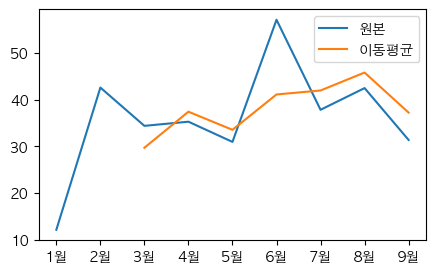

In [3]:
lst = [12.14,42.6,34.4,35.29,30.96,57.12,37.84,42.49,31.38]
plt.rc('font',family='AppleGothic')
df = pd.DataFrame(lst,columns =['data'])
df['roll'] =df.rolling(3).mean()
df.index = [str(i)+'월' for i in range(1,10)]


# from matplotlib import font_manger
# font_manager.get_font_names() 
fig,ax = plt.subplots(1,figsize=(5,3))

plt.plot(df['data'],label='원본')
plt.plot(df.roll,label='이동평균')
plt.legend()
plt.show()

## 문제 4.2
1월 대비 9월의 은의 가격은 몇 % 올랐는가? 소수점 두번째 자리에서 반올림

In [4]:
result = round(((df.loc['9월','data']-df.loc['1월','data']) / df.loc['1월','data']) *100,2)
print(f'1월을 기준으로 9월과의 값의 차이를 1월의 값으로 나누고 100을 곱해서 계산한다. 그결과 {result}% 증가했다.')

1월을 기준으로 9월과의 값의 차이를 1월의 값으로 나누고 100을 곱해서 계산한다. 그결과 158.48% 증가했다.


## 문제설명 (5번)
<img src="https://github.com/Datamanim/datarepo/blob/main/adp/26/problem3.png?raw=true" width="300" height="300">

위 표는 A,B,C 자치구별 W 의원에 대한 찬성, 반대 지지를 나타낸다. 자치구별 지지율이 같은지에 대해서 검정하라

## 문제 5.1 
연구가설과 귀무가설을 설정하라

귀무가설 : 자치구와 w의원에 대한 찬반 지지율은 독립적이다.    
대립가설 (연구가설) : 자치구와 w의원에 대한 찬반 지지율은 서로 연관이 있다. (독립적이지 않다)

## 문제 5.2 
검정통계량을 구하고 결론을 내라

In [6]:
s,p,d,e = chi2_contingency([[176,193,159],[124,107,141]])


print(f'\n답안카이제곱 독립성 검정을 통해 결과를 도출한다. 검정 통계량은 {round(s,3)}이고 p값은 {round(p,3)}이다.\n유의 수준 0.05하에서 귀무가설을 기각한다. 즉 자치구별 지지율이 ')


답안카이제곱 독립성 검정을 통해 결과를 도출한다. 검정 통계량은 7.945이고 p값은 0.019이다.
유의 수준 0.05하에서 귀무가설을 기각한다. 즉 자치구별 지지율이 


## 문제설명 (6번)
A초등학교 남학생 16명과 여학생 9명의 혈압을 측정한 pressure.csv파일을 가지고 남녀학생의 평균 혈압에 차이가 없는지 확인하려한다.
- 데이터 url :https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/26/pressure.csv

## 문제 6.2 
검정 통계량을 구하고 가설 검정을 수행하라

In [19]:
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/26/pressure.csv')

from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind , ttest_rel

m = df[df.gender =='male'].pressure
f = df[df.gender =='female'].pressure
print(mannwhitneyu(m,f))
print(ttest_ind(m,f))

MannwhitneyuResult(statistic=98.0, pvalue=0.14875840681321661)
Ttest_indResult(statistic=1.598335024574904, pvalue=0.12361716364314851)


## 문제 6.3 
6.2의 검정 통계량 값을 바탕으로 신뢰수준 95%하에서 신뢰구간을 설정하라

In [33]:
import numpy as np
from scipy.stats import t

confidence_level = 0.95
alpha = 1 - confidence_level
degrees_of_freedom = len(m) + len(f) - 2
t_critical = t.ppf(1 - alpha / 2, degrees_of_freedom)
std_error = np.sqrt(np.var(m, ddof=1) / len(m) + np.var(f, ddof=1) / len(f))
mean_difference = np.mean(m) - np.mean(f)
confidence_interval = (mean_difference - t_critical * std_error, mean_difference + t_critical * std_error)

print(f"{confidence_level * 100}% Confidence Interval:", confidence_interval)

95.0% Confidence Interval: (-2.2236553334945324, 14.838933111272338)


## 문제설명 (7번)
height(키), weight(몸무게), waist(허리둘레) 컬럼을 가진 problem7.csv파일을 가지고 다음을 분석하라      
A시의 20대 남성 411명을 임의로 추출하여 키, 몸무게, 허리둘레를 조사하여 기록한 데이터이다.         
이 데이터를 이용하여 20대 남성의 키와 허리둘레가 체중에 영향을 미치는지 알아보고자 한다.     

- 데이터 url :https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/26/problem7.csv

## 문제 7.1
아래 조건을 참고하여 회귀계수(반올림하여 소수점 두자리)를 구하시오.    
- 베이지안 회귀   
- 시드넘버 1234로 지정
- 1000번의 burn-in 이후 10,000의 MCMC를 수행
- 회귀계수의 사전분포는 부적절한 균일분포(improper uniform prior distribution), 오차항의 분산의 사전분포는 역감마 분포로 지정. 이때, 형상(Shape)모수와 척도(Scale)모수는 각각 0.005로 지정.

In [1]:
import pandas as pd
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/26/problem7.csv')


In [12]:
import numpy as np
import pystan

# 참고 https://bayestour.github.io/blog/2019/07/08/Bayesian_mediation.html
# !python3.8 -m pip install pystan==2.19.0.0
# 파이썬 버전따라 다르게 설치하세요 import sys ; print(sys.path) 로 버전 확인 가능
# 아나콘다의 경우 conda install pystan==2.19.0.0


X1 = df['height']
X2 = df['waistline']
Y = df['weight']

data = {'N' : len(df), 'x1': X1, 'x2': X2, 'Y': Y}

# Stan 코드

model_code = """

data {
  int<lower=0> N;
  vector[N] x1;
  vector[N] x2;
  vector[N] Y;
}

parameters {
  real a;
  real b1;
  real b2;
  real<lower=0> sigma;
}

model {
  Y ~ normal(a + b1 * x1 + b2 * x2, sigma);
  a ~ normal(0, 1000);
  b1 ~ normal(0, 1000);
  b2 ~ normal(0, 1000);
  sigma ~ gamma(0.005, 0.005);
}

"""

# 모델 핏팅하기

model = pystan.StanModel(model_code=model_code,verbose=True,)
fit = model.sampling(data=data, iter=10000, warmup=1000, chains=1, seed=1234)
fit.summary

<bound method StanFit4Model.summary of Inference for Stan model: anon_model_20749f6857fc9ffcabb643021d4bad8f.
1 chains, each with iter=10000; warmup=1000; thin=1; 
post-warmup draws per chain=9000, total post-warmup draws=9000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a     -124.5    1.08  30.21 -183.7 -144.7 -124.1 -104.5 -66.41    776    1.0
b1      1.04  1.8e-3   0.06   0.92    1.0   1.04   1.08   1.15   1123    1.0
b2      0.22    0.02   0.46  -0.65  -0.08   0.22   0.52   1.14    723    1.0
sigma   1.69  1.2e-3   0.06   1.58   1.65   1.68   1.73   1.81   2422    1.0
lp__  -420.3    0.03   1.44 -423.9 -421.0 -420.0 -419.2 -418.5   1976    1.0

Samples were drawn using NUTS at Mon Aug 28 03:32:59 2023.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).>

In [32]:
b1 = round(fit['b1'].mean(),2)
b2 = round(fit['b2'].mean(),2)
a = round(fit['a'].mean(),2)

<Axes: xlabel='waistline', ylabel='pred'>

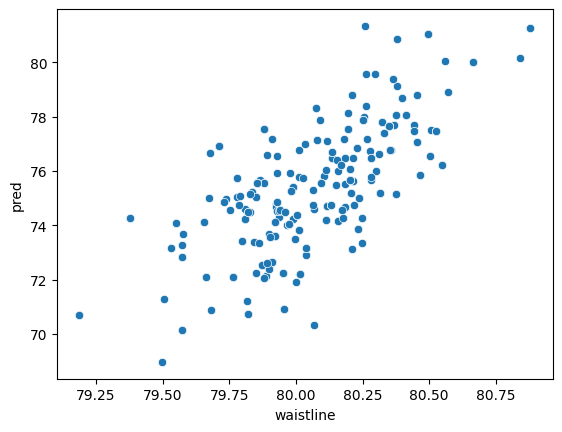

In [43]:
df['pred'] = df['height'] * b1 + df['waistline'] * b2  + a
sns.scatterplot(x=df['waistline'],y=df['pred'])

## 문제 7.2
위에서 만든 모델을 바탕으로 키 180cm, 허리둘레 85cm인 남성의 몸무게를 추정하라

In [44]:
result = 180 * b1 + 85 * b2 + a
print(result)

81.34
